In [1]:
import pandas as pd
from collections import Counter
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# data seems to be lines of json rather than a single object
# loading it into a list so I can carry out merging this way
# only feasible when the data size is small. Wouldn't do this if data size was huge
d = []
with open('../Data/customers.json') as f:
    for line in f:
        d.append(json.loads(line))

In [3]:
# take the first data point and turn it into a dataframe, other data points can then append on this root frame
# (again, it would've been more efficient if this was done on the fly when reading lines off json file 
# but this method in my opinion is more readable)

ordersFrame = pd.DataFrame(d[0]['orders'])
customers_frame = pd.json_normalize(d[0]['customer']) 
ordersFrame['joinkey'], customers_frame['joinkey'] = 0,0 # temporary join key for customer and orders
df = pd.merge(ordersFrame,customers_frame, on='joinkey').drop(columns='joinkey')
df['fraudulent'] = d[0]['fraudulent']

In [4]:
# repeat the above process for all line of json
for i in range(1,len(d)):
    orders_frame = pd.DataFrame(d[i]['orders'])
    customers_frame = pd.json_normalize(d[i]['customer']) 
    orders_frame['joinkey'], customers_frame['joinkey'] = 0,0
    merged_orders_customers = pd.merge(orders_frame,customers_frame, on='joinkey').drop(columns='joinkey')
    merged_orders_customers['fraudulent'] = d[i]['fraudulent']
    df = pd.concat([df, merged_orders_customers], ignore_index=True)

In [5]:
# join the rest of the data on foreign keys
trans = pd.json_normalize(data=d, record_path="transactions")
df = pd.merge(df, trans, on="orderId")
payments = pd.json_normalize(data=d, record_path="paymentMethods")
df = pd.merge(df, payments, on="paymentMethodId")

In [6]:
df.shape

(623, 18)

In [7]:
# transaction id seems to be the primary key here
df.nunique()

orderId                             478
orderAmount                          67
orderState                            3
orderShippingAddress                274
customerEmail                       136
customerPhone                       141
customerDevice                      141
customerIPAddress                   138
customerBillingAddress              139
fraudulent                            2
transactionId                       623
paymentMethodId                     237
transactionAmount                    67
transactionFailed                     2
paymentMethodRegistrationFailure      2
paymentMethodType                     4
paymentMethodProvider                10
paymentMethodIssuer                  19
dtype: int64

In [8]:
# check for missing data
df.isna().sum()

orderId                             0
orderAmount                         0
orderState                          0
orderShippingAddress                0
customerEmail                       0
customerPhone                       0
customerDevice                      0
customerIPAddress                   0
customerBillingAddress              0
fraudulent                          0
transactionId                       0
paymentMethodId                     0
transactionAmount                   0
transactionFailed                   0
paymentMethodRegistrationFailure    0
paymentMethodType                   0
paymentMethodProvider               0
paymentMethodIssuer                 0
dtype: int64

In [9]:
# some arbitrary Id such as orderId wouldn't contribute to fraud classification, so drop
redundant_cols = [x for x in df.columns if ("Id" in x)]

df.drop(redundant_cols, axis=1, inplace=True)

In [10]:
# check for duplicated data
print(df.duplicated().value_counts())
# now that we've dropped the Ids, the remaining values are probably duplicated. 
# This could be genuine duplicates or due to dropped columns. For now, I want to drop it.

df.drop_duplicates(inplace=True)

False    588
True      35
dtype: int64


In [11]:
(df.transactionAmount == df.orderAmount).value_counts()

True    588
dtype: int64

In [12]:
# they seem to be the same thing, drop the redundant column
# customer device seems to be a random string, shouldn't contribute to the cause
df.drop(['transactionAmount','customerDevice'], axis=1, inplace=True)

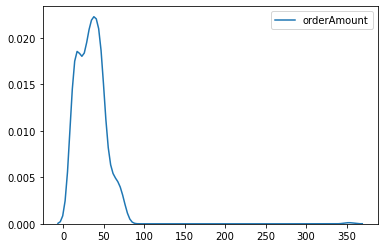

In [13]:
# check the desnity plot of orderAmount
fig, ax = plt.subplots()
sns.kdeplot(df["orderAmount"])

Text(0.5, 0.98, 'OrderAmount vs. Fradulent')

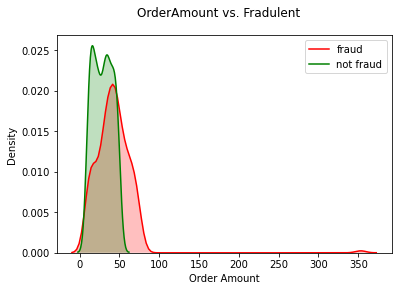

In [14]:
fig, ax = plt.subplots()

sns.kdeplot(df[df["fraudulent"]==True]["orderAmount"], shade=True, color="red", label="fraud", ax=ax)
sns.kdeplot(df[df["fraudulent"]==False]["orderAmount"], shade=True, color="green", label="not fraud", ax=ax)

ax.set_xlabel("Order Amount")
ax.set_ylabel("Density")

fig.suptitle("OrderAmount vs. Fradulent")

Having looked at the plots above, there seems to be a couple of things going on.
- There seems to be outliers around 350 (orderAmount)
- Order amounts more than a certain threshold seem to be mostly, if not all fraudulent
- Order amount seems to be a very important factor in classifying fraudulent behaviour

In [15]:
# see how many outliers there are (more than 3 sigma)
from scipy import stats
df[(np.abs(stats.zscore(df.orderAmount)) > 3)]

,orderAmount,orderState,orderShippingAddress,customerEmail,customerPhone,customerIPAddress,customerBillingAddress,fraudulent,transactionFailed,paymentMethodRegistrationFailure,paymentMethodType,paymentMethodProvider,paymentMethodIssuer
189,353.0,fulfilled,"9596 Christian Bridge\nWest Nicholasbury, OR 9...",uguzman@yahoo.com,(017)893-9493,151.245.182.84,"9596 Christian Bridge\nWest Nicholasbury, OR 9...",True,True,False,card,VISA 16 digit,Her Majesty Trust


In [16]:
# drop the outlier 
df = df[(np.abs(stats.zscore(df.orderAmount)) < 3)]

Text(0, 0.5, 'count')

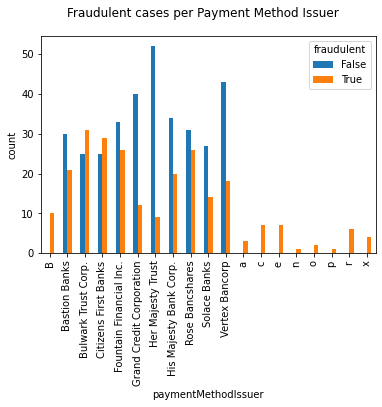

In [17]:
# check the relationship between payment method issuer and fraudulent cases
fig, ax = plt.subplots()
df.groupby(
    ['paymentMethodIssuer', 'fraudulent'])['orderAmount'].count().unstack().plot(kind="bar", ax=ax)

fig.suptitle("Fraudulent cases per Payment Method Issuer")
ax.set_ylabel("count")

From the chart above, we can see that issuers with a single character names are **very** fraudulent

Text(0, 0.5, 'count')

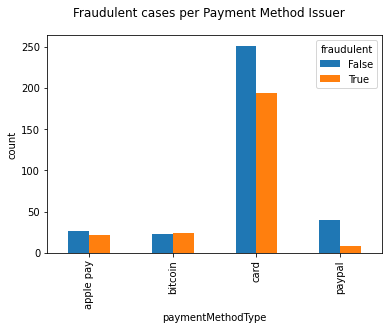

In [18]:
# relationship between payment method type and fraud
fig, ax = plt.subplots()
df.groupby(
    ['paymentMethodType', 'fraudulent'])['orderAmount'].count().unstack().plot(kind="bar", ax=ax)

fig.suptitle("Fraudulent cases per Payment Method Issuer")
ax.set_ylabel("count")

Here, there seems to be no apparent correlation

In [19]:
# I'd imagine the fraud labels takes a while to get to Ravelin so most fraudulent order state would be marked as "fulfilled"
df[df['fraudulent']==True].orderState.value_counts()

fulfilled    208
failed        27
pending       12
Name: orderState, dtype: int64

In [20]:
# most orders seems to have been fulfilled in both fraudulent and non fraudulent cases, I don't think it's a good indicator
df.drop(['orderState'], axis=1, inplace=True)

Text(0, 0.5, 'count')

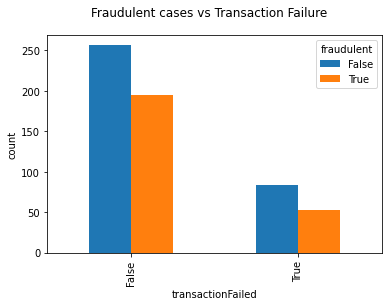

In [21]:
# see if failure in transaction would lead to fraudulent behaviour
fig, ax = plt.subplots()
df.groupby(
    ['transactionFailed', 'fraudulent'])['orderAmount'].count().unstack().plot(kind="bar", ax=ax)

fig.suptitle("Fraudulent cases vs Transaction Failure")
ax.set_ylabel("count")

If the transaction fails, most of the order doesn't go through so it makes sense for there to be comparatively less data when it's true.

In [22]:
# some columns are strings while some are bools and ints, need to encode them
obj_cols = df.select_dtypes(include = "object").columns
bool_cols = df.select_dtypes(include = "boolean").columns

Because of columns such as address and customer phones and ip addresses, one hot encoding would create a lot of columns in the dataset. As the dimension increases, it becomes harder to build a robust model. (Curse of dimensionality). Label encoding seems like a good idea but the data we have are mostly nominal, it might be a problem to train on encoded data as feature X with value 10 will be given more importance than feature X with value of 1. Hash encoding seems to solve the problems above. However, the columns produced by hash encoding isn't intuitve or interpretable. I want to compare how they differ.

#### Label encoded

In [23]:
# keep orignial data for future 
df_original = df.copy(deep=True)

In [24]:
from sklearn.preprocessing import LabelEncoder

lb_enc = LabelEncoder()
for col in obj_cols:   
    df[col] = lb_enc.fit_transform(df[col])

for col in bool_cols:
    df.loc[(df[col] == True),col]=1
    df.loc[(df[col] == False),col]=0

In [25]:
df.head(1).T

,0
orderAmount,18
orderShippingAddress,142
customerEmail,64
customerPhone,96
customerIPAddress,93
customerBillingAddress,70
fraudulent,0
transactionFailed,0
paymentMethodRegistrationFailure,1
paymentMethodType,2


In [26]:
X = df.drop(["fraudulent"],axis=1)
y = df.fraudulent
y=y.astype('int') 

In [27]:
# import ML library and tools
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from collections import Counter
from sklearn.metrics import accuracy_score, classification_report
from os.path import exists
from pathlib import Path
import joblib

In [28]:
Path("../Models/").mkdir(parents=True, exist_ok=True)

In [29]:
# the data isn't quite perfectly balanced, this might cause some problems
Counter(df.fraudulent)

Counter({0: 340, 1: 247})

In [31]:
# define class weight
cw = dict(df.fraudulent.value_counts()/len(df))

# Logistic Regression
lr_model = Pipeline([("model", LogisticRegression(class_weight=cw, solver="liblinear", random_state=123))])
# SVM
svm_model = Pipeline([("model", svm.SVC(kernel="rbf", class_weight=cw))])
# Decision Tree
dt_model = Pipeline([("model", DecisionTreeClassifier(class_weight=cw))])
# Random Forest
rf_model = Pipeline([("model", RandomForestClassifier(class_weight=cw, n_estimators=200, n_jobs=-1))])

In [32]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, y, test_size = 0.3, random_state = 123)

#### Hash encoded

In [33]:
import category_encoders as ce

In [34]:
X_hash = df_original.drop(["fraudulent"],axis=1)
y_hash = df_original.fraudulent
y_hash = y_hash.astype('int') 

In [35]:
ce_hash = ce.HashingEncoder(cols=obj_cols)
X_hash = ce_hash.fit_transform(X_hash,y_hash)

In [36]:
# fraudulent col no longer exists in X_hash
bools = [x for x in bool_cols if x is not "fraudulent"]

In [37]:
for col in bools:
    X_hash.loc[(X_hash[col] == True),col]=1
    X_hash.loc[(X_hash[col] == False),col]=0

In [38]:
Xtrain_hash, Xtest_hash, Ytrain_hash, Ytest_hash = train_test_split(X_hash, y_hash, test_size = 0.3, random_state = 123)

### ML algorithms

In [39]:
def run_random_forest(Xtrain, Xtest, Ytrain, Ytest, name):
    print("Starting Random Forest")
    gs = GridSearchCV(rf_model, {"model__max_depth": [10, 15, 20],
                                 "model__min_samples_split": [5, 10]},
                      n_jobs=-1, cv=5, scoring="accuracy")

    print("Training accuracy:")
    gs.fit(Xtrain, Ytrain)

    print(gs.best_params_)
    print(gs.best_score_)

    rf_model.set_params(**gs.best_params_)
    rf_model.fit(Xtrain, Ytrain)
    print("Testing accuracy:")
    pred = rf_model.predict(Xtest)
    print(accuracy_score(pred,Ytest))
    
    joblib.dump(rf_model, f"../Models/{name}_RF.mdl")
    print("model saved")

In [40]:
def run_svm(Xtrain, Xtest, Ytrain, Ytest, name):
    print("Starting SVM")
    gs = GridSearchCV(svm_model, {"model__C": [0.001, 0.1, 1],
                                 "model__gamma": [0.001, 0.01, 0.1, 1]}, 
                                  n_jobs=-1, cv=5, scoring="accuracy")
    gs.fit(Xtrain, Ytrain)
    
    print(gs.best_params_)
    print("Training accuracy:")
    print(gs.best_score_)

    svm_model.set_params(**gs.best_params_)
    
    
    svm_model.fit(Xtrain, Ytrain)
    print("Testing accuracy:")
    pred = svm_model.predict(Xtest)
    print(accuracy_score(pred,Ytest))
    
    joblib.dump(svm_model, f"../Models/{name}_SVM.mdl")
    print("model saved")

In [41]:
def run_decision_trees(Xtrain, Xtest, Ytrain, Ytest, name):
    print("Starting Decision Trees")
    gs = GridSearchCV(dt_model, {"model__max_depth": [3, 5, 7],
                                 "model__min_samples_split": [2, 5]},
                      n_jobs=-1, cv=5, scoring="accuracy")
    print("Training accuracy:")
    gs.fit(Xtrain, Ytrain)

    print(gs.best_params_)
    print(gs.best_score_)

    dt_model.set_params(**gs.best_params_)
    

    dt_model.fit(Xtrain, Ytrain)
    print("Testing accuracy:")
    pred = dt_model.predict(Xtest)
    print(accuracy_score(pred,Ytest))
    
    joblib.dump(dt_model, f"../Models/{name}_DT.mdl")
    print("model saved")

In [42]:
def run_logistic_regression(Xtrain, Xtest, Ytrain, Ytest, name):
    print("Starting Logistic Regression")
    gs = GridSearchCV(lr_model, {"model__C": [1, 1.3, 1.5]}, 
                      n_jobs=-1, cv=5, scoring="accuracy")
    print("Training accuracy:")
    gs.fit(Xtrain, Ytrain)

    print(gs.best_params_)
    print(gs.best_score_)

    lr_model.set_params(**gs.best_params_)

    lr_model.fit(Xtrain, Ytrain)
    print("Testing accuracy:")
    pred = lr_model.predict(Xtest)
    print(accuracy_score(pred,Ytest))
    
    joblib.dump(lr_model, f"../Models/{name}_LR.mdl")
    print("model saved")

#### Training on label encoded data

In [43]:
run_svm(Xtrain, Xtest, Ytrain, Ytest, "label_encoded")
print("="*20)
run_random_forest(Xtrain, Xtest, Ytrain, Ytest, "label_encoded")
print("="*20)
run_decision_trees(Xtrain, Xtest, Ytrain, Ytest, "label_encoded")
print("="*20)
run_logistic_regression(Xtrain, Xtest, Ytrain, Ytest, "label_encoded")

Starting SVM
{'model__C': 1, 'model__gamma': 0.001}
Training accuracy:
0.6975609756097562
Testing accuracy:
0.751412429378531
model saved
Starting Random Forest
Training accuracy:
{'model__max_depth': 15, 'model__min_samples_split': 5}
0.9390243902439025
Testing accuracy:
0.9378531073446328
model saved
Starting Decision Trees
Training accuracy:
{'model__max_depth': 7, 'model__min_samples_split': 5}
0.7682926829268293
Testing accuracy:
0.807909604519774
model saved
Starting Logistic Regression
Training accuracy:
{'model__C': 1.3}
0.6804878048780487
Testing accuracy:
0.6892655367231638
model saved


#### Training on hash encoded data

In [44]:
run_svm(Xtrain_hash, Xtest_hash, Ytrain_hash, Ytest_hash, "hash_encoded")
print("="*20)
run_random_forest(Xtrain_hash, Xtest_hash, Ytrain_hash, Ytest_hash, "hash_encoded")
print("="*20)
run_decision_trees(Xtrain_hash, Xtest_hash, Ytrain_hash, Ytest_hash, "hash_encoded")
print("="*20)
run_logistic_regression(Xtrain_hash, Xtest_hash, Ytrain_hash, Ytest_hash, "hash_encoded")

Starting SVM
{'model__C': 1, 'model__gamma': 0.01}
Training accuracy:
0.7024390243902439
Testing accuracy:
0.6836158192090396
model saved
Starting Random Forest
Training accuracy:
{'model__max_depth': 20, 'model__min_samples_split': 5}
0.8195121951219513
Testing accuracy:
0.7966101694915254
model saved
Starting Decision Trees
Training accuracy:
{'model__max_depth': 7, 'model__min_samples_split': 2}
0.7414634146341464
Testing accuracy:
0.7740112994350282
model saved
Starting Logistic Regression
Training accuracy:
{'model__C': 1}
0.7219512195121951
Testing accuracy:
0.6949152542372882
model saved


## Model interpretability

In [45]:
import eli5

/usr/local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


##### Label encoded

In [46]:
# load random forest
label_rf_model = joblib.load("../Models/label_encoded_RF.mdl")

feature_names_label = list(X.columns)

y_pred = label_rf_model.predict(Xtest)

print("Random forest Accuracy: ", accuracy_score(Ytest, y_pred))

print("Classification report:\n",
        classification_report(Ytest, y_pred))

eli5.show_weights(label_rf_model.named_steps["model"], feature_names=feature_names_label, top=20)

Random forest Accuracy:  0.9378531073446328
Classification report:
               precision    recall  f1-score   support

           0       0.91      0.98      0.95        97
           1       0.97      0.89      0.93        80

    accuracy                           0.94       177
   macro avg       0.94      0.93      0.94       177
weighted avg       0.94      0.94      0.94       177



Weight,Feature
0.2471 ± 0.1541,orderAmount
0.1481 ± 0.1684,customerIPAddress
0.1312 ± 0.1346,customerEmail
0.1205 ± 0.0923,paymentMethodIssuer
0.0984 ± 0.1103,customerBillingAddress
0.0900 ± 0.1071,customerPhone
0.0787 ± 0.0909,orderShippingAddress
0.0445 ± 0.0625,paymentMethodProvider
0.0253 ± 0.0390,paymentMethodType
0.0128 ± 0.0364,paymentMethodRegistrationFailure


###### Hash encoded

In [47]:
# load random forest
hash_rf_model = joblib.load("../Models/hash_encoded_RF.mdl")

feature_names_hash = list(X_hash.columns)

y_pred = hash_rf_model.predict(Xtest_hash)

print("Random forest Accuracy: ", accuracy_score(Ytest_hash, y_pred))

print("Classification report:\n",
        classification_report(Ytest_hash, y_pred))

eli5.show_weights(hash_rf_model.named_steps["model"], feature_names=feature_names_hash, top=20)

Random forest Accuracy:  0.7966101694915254
Classification report:
               precision    recall  f1-score   support

           0       0.75      0.94      0.83        97
           1       0.89      0.62      0.74        80

    accuracy                           0.80       177
   macro avg       0.82      0.78      0.79       177
weighted avg       0.82      0.80      0.79       177



Weight,Feature
0.3596 ± 0.1568,orderAmount
0.1042 ± 0.0796,col_2
0.0942 ± 0.0719,col_7
0.0761 ± 0.0700,col_6
0.0718 ± 0.0611,col_0
0.0698 ± 0.0541,col_5
0.0637 ± 0.0633,col_1
0.0632 ± 0.0566,col_4
0.0587 ± 0.0592,col_3
0.0234 ± 0.0356,paymentMethodRegistrationFailure
